In [2]:
import os
from dotenv import load_dotenv
load_dotenv(dotenv_path='../.env')
from langchain_groq import ChatGroq

In [3]:
llm = ChatGroq(
    temperature = 0,
    groq_api_key = os.getenv("groq_api_key"),
    model_name = os.getenv("llama_model_name2")
    )

In [4]:
llm.invoke('Hi').content

'Hi there! 👋\n\nWhat can I do for you today? 😊\n'

In [5]:
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.graph.message import add_messages, AnyMessage
from typing import Annotated, Literal, TypedDict
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode

In [6]:
def call_model(state:MessagesState):
    messages = state['messages']
    response = llm.invoke(messages)
    return {"messages":[response]}

In [7]:
workflow = StateGraph(MessagesState)

workflow.add_node("chatbot", call_model)
workflow.add_edge(START, "chatbot")
workflow.add_edge("chatbot", END)

app = workflow.compile()

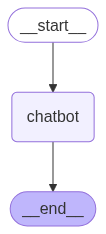

In [8]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [9]:
class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [10]:
input = {"messages":["Hi, my name is sunny"]}

In [11]:
app.invoke(input)

{'messages': [HumanMessage(content='Hi, my name is sunny', additional_kwargs={}, response_metadata={}, id='65150aba-fbd7-49df-9791-e7a925002f0e'),
  AIMessage(content="Hi Sunny, it's nice to meet you! 👋\n\nWhat can I do for you today? 😊  \n\n", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 15, 'total_tokens': 42, 'completion_time': 0.049090909, 'prompt_time': 0.001264619, 'queue_time': 0.253861827, 'total_time': 0.050355528}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None}, id='run--cb2bde04-326d-44b3-90df-d869021d3825-0', usage_metadata={'input_tokens': 15, 'output_tokens': 27, 'total_tokens': 42})]}

In [12]:
for output in app.stream(input):
    for key, value in output.items():
        print(f"Output from {key} Node")
        print('---------')
        print(value)
        print('\n')

Output from chatbot Node
---------
{'messages': [AIMessage(content="Hi Sunny, it's nice to meet you! 👋\n\nWhat can I do for you today? 😊  \n\n", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 15, 'total_tokens': 42, 'completion_time': 0.049090909, 'prompt_time': 0.00124592, 'queue_time': 0.253369556, 'total_time': 0.050336829}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None}, id='run--f86460a4-5918-4b91-9346-26e2a065b646-0', usage_metadata={'input_tokens': 15, 'output_tokens': 27, 'total_tokens': 42})]}




In [13]:
@tool
def search(query: str):
    """this is my custom tool."""
    if "sf" in query.lower() or "san francisco" in query.lower():
        return "It's 60 degrees and foggy."
    return "It's 90 degrees and sunny." 

In [14]:
search.invoke("what is a temprature in sf?")

"It's 60 degrees and foggy."

In [15]:
search.invoke("what is a weather in india?")

"It's 90 degrees and sunny."

In [16]:
search

StructuredTool(name='search', description='this is my custom tool.', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x000001C099934A40>)

In [17]:
tools = [search]
tool_node = ToolNode(tools)

In [18]:
llm_with_tool = llm.bind_tools(tools)

In [19]:
def call_model(state: MessagesState):
    messages = state['messages']
    response = llm_with_tool.invoke(messages)
    return {"messages": [response]}

In [20]:
response=call_model({"messages": ["hi how are you?"]})

In [21]:
response

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '0m8e4zfsy', 'function': {'arguments': '{"query":"hi how are you"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 81, 'prompt_tokens': 940, 'total_tokens': 1021, 'completion_time': 0.147272727, 'prompt_time': 0.017983565, 'queue_time': 0.255448249, 'total_time': 0.165256292}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--e7892576-621d-4ab5-97cf-eb0a91dac994-0', tool_calls=[{'name': 'search', 'args': {'query': 'hi how are you'}, 'id': '0m8e4zfsy', 'type': 'tool_call'}], usage_metadata={'input_tokens': 940, 'output_tokens': 81, 'total_tokens': 1021})]}

In [22]:
messages = response['messages']

In [23]:
last_message=messages[-1]

In [24]:
last_message.tool_calls

[{'name': 'search',
  'args': {'query': 'hi how are you'},
  'id': '0m8e4zfsy',
  'type': 'tool_call'}]

In [25]:
response = call_model({"messages": ["what is a weather in India?"]})

In [26]:
response

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '1crtrm9fh', 'function': {'arguments': '{"query":"weather in India"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 82, 'prompt_tokens': 942, 'total_tokens': 1024, 'completion_time': 0.149090909, 'prompt_time': 0.017960795, 'queue_time': 0.256856039, 'total_time': 0.167051704}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--284719e8-fd46-41fa-a2dd-99a04115814c-0', tool_calls=[{'name': 'search', 'args': {'query': 'weather in India'}, 'id': '1crtrm9fh', 'type': 'tool_call'}], usage_metadata={'input_tokens': 942, 'output_tokens': 82, 'total_tokens': 1024})]}

In [27]:
messages = response['messages']
last_message=messages[-1]
last_message.tool_calls

[{'name': 'search',
  'args': {'query': 'weather in India'},
  'id': '1crtrm9fh',
  'type': 'tool_call'}]

In [28]:
def router_function(state: MessagesState) -> Literal["tools", END]:
    #print(f"here is a state from should continue {state}")
    messages = state['messages']
    last_message = messages[-1]
    #print(f"here is a last message from should continue {last_message}")
    if last_message.tool_calls:
        return "tools"
    return END

In [29]:
# Define a new graph
workflow = StateGraph(MessagesState)

workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

workflow.add_edge(START, "agent")

workflow.add_conditional_edges("agent",router_function,{"tools": "tools", END: END})

app = workflow.compile()

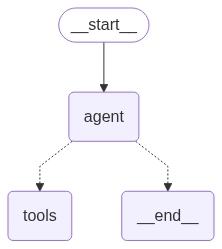

In [30]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [31]:
app.invoke({"messages": ["hi how are you?"]})

{'messages': [HumanMessage(content='hi how are you?', additional_kwargs={}, response_metadata={}, id='6f726dfb-e9ad-4261-8b21-98cf5329e96a'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '2xb1wr3vr', 'function': {'arguments': '{"query":"hi how are you"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 81, 'prompt_tokens': 940, 'total_tokens': 1021, 'completion_time': 0.147272727, 'prompt_time': 0.017994094, 'queue_time': 0.25426716, 'total_time': 0.165266821}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--593bf579-5371-4e7c-b47c-e99d16867096-0', tool_calls=[{'name': 'search', 'args': {'query': 'hi how are you'}, 'id': '2xb1wr3vr', 'type': 'tool_call'}], usage_metadata={'input_tokens': 940, 'output_tokens': 81, 'total_tokens': 1021}),
  ToolMessage(content="It's 90 degrees and sunny.", name='search', id='a73c8c62-3407-4dc2-85a9-56ef3d06

In [32]:
app.invoke({"messages": ["what is the weather in sf"]})

{'messages': [HumanMessage(content='what is the weather in sf', additional_kwargs={}, response_metadata={}, id='6a1ef965-7227-44af-8d06-52a7b02f888c'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'kdkz7qera', 'function': {'arguments': '{"query":"weather in sf"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 82, 'prompt_tokens': 941, 'total_tokens': 1023, 'completion_time': 0.149090909, 'prompt_time': 0.018030784, 'queue_time': 0.25665061, 'total_time': 0.167121693}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--1425fde7-adbf-4763-a317-c7c5dda96061-0', tool_calls=[{'name': 'search', 'args': {'query': 'weather in sf'}, 'id': 'kdkz7qera', 'type': 'tool_call'}], usage_metadata={'input_tokens': 941, 'output_tokens': 82, 'total_tokens': 1023}),
  ToolMessage(content="It's 60 degrees and foggy.", name='search', id='83e06e05-162c-486c-9157-

In [33]:
workflow.add_edge("tools", 'agent')

Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.


In [34]:
app = workflow.compile()

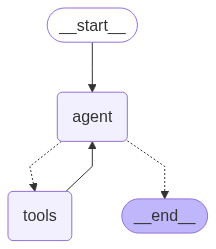

In [35]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [36]:
for output in app.stream({"messages": ["what is the weather in sf"]}):
    for key,value in output.items():
        print(f"here is output from {key}")
        print("-------")
        print(value)
        print("\n")

here is output from agent
-------
{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'w2qy6wvss', 'function': {'arguments': '{"query":"weather in sf"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 82, 'prompt_tokens': 941, 'total_tokens': 1023, 'completion_time': 0.149090909, 'prompt_time': 0.018018255, 'queue_time': 0.257520409, 'total_time': 0.167109164}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--996a93c0-968f-4602-84f1-e1b4bf055e8c-0', tool_calls=[{'name': 'search', 'args': {'query': 'weather in sf'}, 'id': 'w2qy6wvss', 'type': 'tool_call'}], usage_metadata={'input_tokens': 941, 'output_tokens': 82, 'total_tokens': 1023})]}


here is output from tools
-------
{'messages': [ToolMessage(content="It's 60 degrees and foggy.", name='search', id='f25846a1-df38-49f2-9e2b-84fe9ac53db5', tool_call_id='w2qy6wvss')]}


here is out

In [37]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [38]:
# Define a new graph
workflow3 = StateGraph(MessagesState)

workflow3.add_node("agent", call_model)
workflow3.add_node("tools", tool_node)

workflow3.add_edge(START, "agent")

workflow3.add_conditional_edges("agent",router_function,{"tools": "tools", END: END})

workflow3.add_edge("tools", 'agent')

In [39]:
app3 = workflow3.compile(checkpointer = memory)

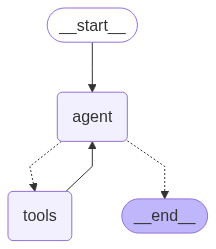

In [40]:
from IPython.display import Image, display

try:
    display(Image(app3.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [41]:
config = {"configurable": {"thread_id": "1"}}

In [42]:
events = app3.stream(
    {"messages": ["Hi there! My name is Sunny."]}, config, stream_mode="values"
)

In [43]:
for event in events:
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Sunny.
================================== Ai Message ==================================
Tool Calls:
  search (ajf6bv22k)
 Call ID: ajf6bv22k
  Args:
    query: Hi there! My name is Sunny.
================================= Tool Message =================================
Name: search

It's 90 degrees and sunny.
================================== Ai Message ==================================
Tool Calls:
  search (by4edwpew)
 Call ID: by4edwpew
  Args:
    query: What is the weather like?
================================= Tool Message =================================
Name: search

It's 90 degrees and sunny.
================================== Ai Message ==================================

It's 90 degrees and sunny.
